<a href="https://colab.research.google.com/github/patrickbryant1/binder_design/blob/main/EvoBind.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Connect to Google drive
#@markdown You have to allow to **connect to Google drive** in order to run EvoBind.
#Mount the drive to be able to save files
from google.colab import drive
import os, sys
drive.mount('/content/gdrive') #All the output will be written here

**EvoBind** designs peptide binders with state-of-the-art accuracy using a combination of [Foldseek](https://search.foldseek.com), [ESM-IF1](https://www.biorxiv.org/content/10.1101/2022.04.10.487779v2) and [AlphaFold](https://www.nature.com/articles/s41586-021-03819-2).

Foldseek is available under [GNU GPL-3.0](https://www.gnu.org/licenses/gpl-3.0.en.html). \
ESM-IF1 is available under the [MIT license](https://opensource.org/licenses/MIT). \
AlphaFold2 is available under the [Apache License, Version 2.0](http://www.apache.org/licenses/LICENSE-2.0). \
The AlphaFold2 parameters are made available under the terms of the [CC BY 4.0 license](https://creativecommons.org/licenses/by/4.0/legalcode) and have not been modified.


EvoBind is available under the same licenses as a derivative of these methods.  

**You may not use these files except in compliance with the licenses.**


**NOTE!** \
This notebook may require more RAM than available under the free Colab version due to the size of the networks used. This depends on the size of the recptor-binder complex being predicted. Consider upgrading to Colab Pro before using this notebook.

In [ ]:
#@title Install dependencies

#@markdown Make sure your runtime is GPU. 
#@markdown In the menu above do: Runtime --> Change runtime type --> Hardware accelerator (set to GPU)

#@markdown **Press play.**

#@markdown You will have to **restart** the runtime after this finishes to include the new packages.
#@markdown In the menu above do: Runtime --> Restart runtime 

#@markdown **After restarting** - reconnect to Google drive.
!pip install "jax[cuda]==0.3.22" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

import torch

!pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
!pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

!pip install  biopython==1.79
!pip install  ml-collections==0.1.0
!pip install  chex==0.0.7
!pip install  dm-tree==0.1.6
!pip install  immutabledict==2.0.0
!pip install  numpy==1.19.5
!pip install  pandas==1.3.4
!pip install  scipy==1.7.0
!pip install  py3Dmol
!pip install  biotite
!pip install  git+https://github.com/facebookresearch/esm.git
!pip install  torch
!pip install  dm-haiku==0.0.7
!pip install  tensorflow-cpu==2.5.0


In [ ]:
#@title Clone the EvoBind github repository
import shutil
try:
  shutil.rmtree('/content/binder_design', ignore_errors=True)
except:
  print('')

!git clone https://github.com/patrickbryant1/binder_design.git

In [3]:
#@title #Follow all steps outlined below to design a binder.
#@markdown To try the **test case** [1LDJ](https://www.rcsb.org/3d-view/1LDJ), press the play button to the left.
\
#@markdown If you don't want to run the test case, **change the input parameters**.

#@markdown #Parameters
#@markdown - *PDBID* - PDB id of the receptor structure 
#@markdown - *TARGET_CHAIN* - what chain in the PDB file to design towards
#@markdown - **Optional**: *UPLOAD_CIF* - if you prefer to upload a file instead, you can simply do this. 
#@markdown Click the folder icon (Files) to the left and select the upload file icon. \
#@markdown Make sure the file is named **PDBID**_**TARGET_CHAIN**.cif, where PDBID is the specified one below.

import sys, os
from google.colab import files
import pandas as pd
import numpy as np
import urllib.request
import py3Dmol
import matplotlib.pyplot as plt
import glob
sys.path.insert(0,'/content/binder_design/src/process')
PDBID = "1LDJ" #@param {type:"string"}
TARGET_CHAIN = "A" #@param {type:"string"}
UPLOAD_CIF = False #@param {type:"boolean"}


OUTDIR="/content/gdrive/MyDrive/"+PDBID+'/'
#Make outdir
if not os.path.exists(OUTDIR):
  os.mkdir(OUTDIR)
#Get structure
TARGET_STRUCTURE = "https://files.rcsb.org/download/"+PDBID

#Load the PDB
print('Getting structure file...')
if UPLOAD_CIF==True:
  TARGET_STRUCTURE='/content/'+PDBID+'.cif'
else:
  if not os.path.exists(OUTDIR+PDBID+".cif"):
    try:
      urllib.request.urlretrieve(TARGET_STRUCTURE+".cif", OUTDIR+PDBID+".cif")
    except:
      print("Can't download file: "+TARGET_STRUCTURE+'. Ensure that the PDBID is correct.')

#Parse the intended chain
from generate_diverse_seeds import prepare_input
import warnings
warnings.filterwarnings('ignore')
prepare_input(OUTDIR+PDBID+".cif", TARGET_CHAIN, OUTDIR, PDBID)
#Vis
view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',)
view.addModel(open(OUTDIR+PDBID+'_'+TARGET_CHAIN+'.pdb','r').read(),'pdb')
view.setStyle({'chain':TARGET_CHAIN},{'cartoon': {'color':'grey'}})
view.zoomTo()
view.show()
print('Ensure this is your intended target.')


Getting structure file...


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Ensure this is your intended target.


In [4]:
#@markdown #Run [Foldseek](https://search.foldseek.com) 
#@markdown Press play and paste the resulting id into the next cell to download the results
INFILE=OUTDIR+PDBID+'_'+TARGET_CHAIN+'.pdb'
! curl -X POST -F q=@$INFILE -F 'mode=3diaa'  -F 'database[]=pdb100' https://search.foldseek.com/api/ticket


{"id":"cXAIyEDPIXwWbLxC37uFpd6yTpsZR0Qy9if4uA","status":"COMPLETE"}


In [ ]:
#@markdown #Download results
SEARCH_ID = "cXAIyEDPIXwWbLxC37uFpd6yTpsZR0Qy9if4uA" #@param {type:"string"}
#Download
! wget https://search.foldseek.com/api/result/download/$SEARCH_ID -O $OUTDIR/result.tar.gz
#Unzip
! tar -xvzf $OUTDIR/result.tar.gz -C $OUTDIR

In [6]:
#@markdown #Parse the hits and select seeds for the design
from generate_diverse_seeds import parse_results, write_ids_for_download, get_interaction_seeds, write_seeds_for_design
import pandas as pd
#Parse the results
aln_seqs, pdb_ids, pdb_chains = parse_results(OUTDIR)
#Write the IDs
write_ids_for_download(pdb_ids, OUTDIR+'ids.txt')
#Download
print('Downloading hits from the PDB...')
IDS=OUTDIR+'ids.txt'
MMCIFDIR=OUTDIR+'mmcif/'
! if [ -d "$MMCIFDIR" ]; then   echo "$MMCIFDIR exists..."; else mkdir $MMCIFDIR; bash /content/binder_design/src/process/batch_download.sh -f $IDS -c -o $MMCIFDIR; fi

#Unzip
!gunzip $MMCIFDIR/*.gz 
#Get seeds
SEEDDIR=MMCIFDIR+'seeds/'
!mkdir $SEEDDIR
#@markdown Min and max lengths of seeds for the binders:
MIN_LENGTH = 10 #@param {type:"integer"}
MAX_LENGTH = 25 #@param {type:"integer"}
#@markdown Min contact density (contacts per position):
MIN_CONTACT_DENSITY = 2 #@param {type:"slider", min:0, max:5, step:0.1}
#@markdown Min centre of mass distance between seeds (Ångström):
DELTA_COM = 2 #@param {type:"number"}
try:
  seed_df = pd.read_csv(SEEDDIR+'seed_df.csv')
  print('Seed df exists...')
  print('Using seed df:', SEEDDIR+'seed_df.csv')
  print('If you want to pick new seeds, remove the seed df.')
except:
  print('Getting seeds...')
  seed_df = get_interaction_seeds(pdb_ids, pdb_chains, MMCIFDIR, MIN_LENGTH, MAX_LENGTH, SEEDDIR)
  #Pick seeds based on contact density and COM diff (avoid repetitive seeds)
  print('Picking seeds...')
  write_seeds_for_design(seed_df, OUTDIR+PDBID+".cif", MMCIFDIR, SEEDDIR, MIN_CONTACT_DENSITY, DELTA_COM)

/content/gdrive/MyDrive/1LDJ/mmcif/ exists...
gzip: /content/gdrive/MyDrive/1LDJ/mmcif//*.gz: No such file or directory
mkdir: cannot create directory ‘/content/gdrive/MyDrive/1LDJ/mmcif/seeds/’: File exists
Seed df exists...
Using seed df: /content/gdrive/MyDrive/1LDJ/mmcif/seeds/seed_df.csv
If you want to pick new seeds, remove the seed df.


In [7]:
#@markdown #Visualize the binder seeds
#@markdown How many seeds to pick (based on highest contact density)
MMCIFDIR=OUTDIR+'mmcif/'
SEEDDIR=MMCIFDIR+'seeds/'
NUM_SEEDS = 1 #@param {type:"slider", min:1, max:10, step:1}
import glob
import py3Dmol
SEEDS=glob.glob(SEEDDIR+'*.pdb')
view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',)
COLORS=["orange", "cyan","magenta","yellow","salmon","white",
        "skyblue","lime", "grey","brown"]

#Print contact density
seed_df = pd.read_csv(SEEDDIR+'seed_df.csv')
print('Contact density for seed:')
for i in range(NUM_SEEDS):
  row = seed_df.loc[i]
  print(str(i+1)+':',np.round(row.contacts/row.croplen,1))

print('The grey chains are the target backbones and the blue the seeds.')
for model in SEEDS[:NUM_SEEDS]:
  view.addModel(open(model,'r').read(),'pdb')
  view.setStyle({'chain':'A'},{'stick': {'color':'grey'}})
  view.setStyle({'chain':'B'},{'stick': {'color':'blue'}})
view.zoomTo()
view.show()




Contact density for seed:
1: 6.1
The grey chains are the target backbones and the blue the seeds.


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [ ]:
#@markdown #Design sequences using a modified version of [ESM-IF1](https://www.biorxiv.org/content/10.1101/2022.04.10.487779v2)
#@markdown How many examples to generate per seed (using the number of seeds picked above):
NUM_DESIGNS_PER_SEED = 10 #@param {type:"integer"}
#@markdown How much noise to add to the ESM-IF1 sampling (temperature). For optimal native sequence recovery use 1e-6, for optimal diversity use 1 (default).
ESM_NOISE = 1 #@param {type:"number"}
#@markdown How much of the receptor to use around the target region of the seed. This is to reduce the RAM requirement.
MAX_RECEPTOR_LENGTH = 200 #@param {type:"integer"}
import glob
if len(glob.glob(SEEDDIR+'esm_seed_*.csv'))>0:
  print('Found existing designs:')
  print(glob.glob(SEEDDIR+'esm_seed_*.csv'))
  print('Remove these if you want to generate new ones...')
else:
  sys.path.insert(0,'/content/binder_design/src/')
  from esm_if1_pred import design_seqs, read_pdb
  import glob
  sn=1
  for seed in SEEDS[:NUM_SEEDS]:
    if len(glob.glob(SEEDDIR+'esm_seed_'+str(sn)+'.csv'))<1:
      model_coords, model_seqs, model_atoms, model_resnos = read_pdb(seed)
      design_df = design_seqs(NUM_DESIGNS_PER_SEED, model_coords['A'], model_coords['B'], 
                  model_atoms['A'], model_atoms['B'], model_seqs['A'], model_seqs['B'], 
                  MAX_RECEPTOR_LENGTH, t=ESM_NOISE)
      design_df.to_csv(SEEDDIR+'esm_seed_'+str(sn)+'.csv', index=None)
    else:
      print('Designs exist for seed',sn)
    sn+=1

In [9]:
#@markdown #Get MSA for the target
#@markdown There are two options for this: \
#@markdown 1. Create a sequence alignment from a structural alignment generated with Foldseek towards many different structural databases: \
#@markdown afdb50, afdb-swissprot, afdb-proteome, mgnify_esm30, pdb100 and gmgcl_id \
#@markdown If this is your option, follow the steps in the next cell to generate an msa.

#@markdown 2. Go to https://toolkit.tuebingen.mpg.de/tools/hhblits \
#@markdown Paste the target sequence in the search field in fasta format --> Submit. \
#@markdown The *target sequence* is **printed** when pressing play here. \
#@markdown When the search is finished, go to the tab "Query Template MSA" and "Download Full A3M" \ 
#@markdown - Upload the MSA here: \
#@markdown Click the folder icon (Files) to the left and select the upload file icon. Upload the .a3m file.
#@markdown Make sure the MSA is named **PDBID**_**TARGET_CHAIN**.a3m, where PDBID is the PDBID specified above.
OPTION = "1" #@param ["1", "2"]

sys.path.insert(0,'/content/binder_design/src/')
TARGET_STRUCTURE=OUTDIR+PDBID+'_'+TARGET_CHAIN+'.pdb'
from esm_if1_pred import read_pdb
model_coords, model_seqs, model_atoms, model_resnos = read_pdb(TARGET_STRUCTURE)
target_seq = model_seqs[TARGET_CHAIN][np.argwhere(model_atoms[TARGET_CHAIN]=='CA')[:,0]]
three_to_one = {'ARG':'R', 'HIS':'H', 'LYS':'K', 'ASP':'D', 'GLU':'E', 'SER':'S', 'THR':'T', 'ASN':'N', 'GLN':'Q', 'CYS':'C', 'GLY':'G', 'PRO':'P', 'ALA':'A', 'ILE':'I', 'LEU':'L', 'MET':'M', 'PHE':'F', 'TRP':'W', 'TYR':'Y', 'VAL':'V',
    'SEC':'U', 'PYL':'O', 'GLX':'X', 'UNK': 'X'}
target_seq=''.join([three_to_one[x] for x in target_seq])
#Write fasta for target seq
with open(OUTDIR+PDBID+'_'+TARGET_CHAIN+'.fasta', 'w') as file:
  file.write('>'+PDBID+'_'+TARGET_CHAIN+'\n')
  file.write(target_seq)
if OPTION=='2':
  print('TARGET SEQUENCE:',target_seq)
else:
  INFILE=OUTDIR+PDBID+'_'+TARGET_CHAIN+'.pdb'
  ! curl -X POST -F q=@$INFILE -F 'mode=3diaa'  -F 'database[]=afdb50' -F 'database[]=afdb-swissprot' -F 'database[]=afdb-proteome' -F 'database[]=mgnify_esm30' -F 'database[]=pdb100' -F 'database[]=gmgcl_id'  https://search.foldseek.com/api/ticket


{"id":"PAzuk-2QykHT3RdSxiM_Nf4dXlqzLtqNL3PU9w","status":"COMPLETE"}


In [ ]:
#@markdown #Get the results for OPTION 1
#@markdown If you chose to generate a structural alignment from above (option 1), paste the resulting id here to start the generation process. \
\
#@markdown Make sure the status is "COMPLETE", refresh using the play-button in the previous cell until this is true.
sys.path.insert(0,'/content/binder_design/src/process')
import os
from str_to_seq_aln import make_aln, write_a3m
SEARCH_ID = "J3xrgeXfYzPVEFp8jrGqkCORR0u9X2fLcpsb6w" #@param {type:"string"}
#@markdown E-value threshold for including hits in the alignment
eval_threshold = 0.1 #@param {type:"number"}
if os.path.exists(OUTDIR+'/str_aln/'+PDBID+'_str.a3m'):
  print('A str aln for', PDBID+'_'+TARGET_CHAIN, 'exists...')
else:
  #Download
  ! wget https://search.foldseek.com/api/result/download/$SEARCH_ID -O $OUTDIR/result.tar.gz
  #Unzip
  ! mkdir $OUTDIR/str_aln
  ! tar -xvzf $OUTDIR/result.tar.gz -C $OUTDIR/str_aln/
  #Create MSA
  print('Making alignment..')
  aln, ids, evals = make_aln(target_seq, OUTDIR+'/str_aln/',eval_threshold)
  write_a3m(OUTDIR+'/str_aln/'+PDBID+'_str.a3m', aln, ids, evals)

In [ ]:
#@markdown #Evaluate the designed sequences using our modified version of [AlphaFold](https://www.nature.com/articles/s41586-021-03819-2) adapted to binder evaluation.
#@markdown The designed sequences are predicted in complex with the target. 
#@markdown The predictions are used below to assess the designs by calculating a custom bind-score.

#@markdown The AF2 params are fetched here (if they are not already downloaded).
import shutil
PARAMS="/content/gdrive/MyDrive/AF/params/"
if not os.path.exists(PARAMS):
  if not os.path.exists('/content/gdrive/MyDrive/AF/'):
    os.mkdir('/content/gdrive/MyDrive/AF/')
  os.mkdir(PARAMS)
  !wget https://storage.googleapis.com/alphafold/alphafold_params_2021-07-14.tar 
  shutil.move('/content/alphafold_params_2021-07-14.tar', PARAMS)
  #Extract
  !tar -xvf /content/gdrive/MyDrive/AF/params/alphafold_params_2021-07-14.tar -C /content/gdrive/MyDrive/AF/params/

#Predict
sys.path.insert(0,'/content/binder_design/src/AF2')
from af_mod_pred import run_preds
TARGET_FASTA=OUTDIR+PDBID+'_'+TARGET_CHAIN+'.fasta'
if OPTION=='1':
  TARGET_MSA=OUTDIR+'/str_aln/'+PDBID+'_str.a3m'
else:
  TARGET_MSA='/content/'+PDBID+'_'+TARGET_CHAIN+'.a3m'

#Make output dir
!mkdir $OUTFIR'/AF/'
#Parameters for AF
NUM_ENSEMBLE=1
#@markdown Try increasing the number of recycles for harder targets.
MAX_RECYCLES = 3 #@param {type:"integer"}

sn=1
for seed in SEEDS[:NUM_SEEDS]:
  PEPTIDE_SEQS=pd.read_csv(SEEDDIR+'esm_seed_'+str(sn)+'.csv')

  run_preds(TARGET_FASTA, TARGET_MSA, NUM_ENSEMBLE, MAX_RECYCLES, 
            '/content/gdrive/MyDrive/AF/', PEPTIDE_SEQS.designed_binder_seq.values, 
            OUTDIR+'AF/', 'seed_'+str(sn))

  sn+=1


Prediction took 856.1546795368195 s
Prediction took 659.6084818840027 s


Scoring of seed 1
Pred 1 loss: 1.2 plddt: 35.2


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

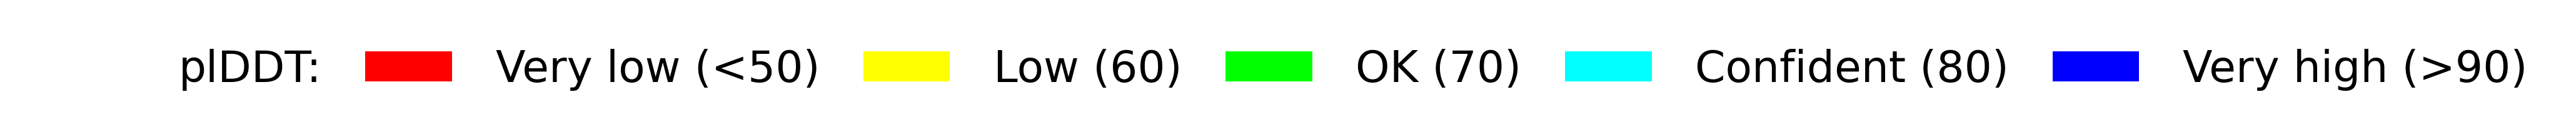

In [25]:
#@markdown #Score the designs
#@markdown At a loss (or bind score) <1 with a plDDT>80, there is a 95% TPR of binding. \
#@markdown Obtaining designs dislaying scores below these thresholds should be your objective.

#@markdown How many designs to show per seed (starting from the best ones).
TOP_N = 1 #@param {type:"integer"}

#Add a loop: https://william-dawson.github.io/using-py3dmol.html
#@markdown Style of the target receptor. The color is fixed as grey.
RECEPTOR_STYLE = "cartoon" #@param ["cartoon", "sphere", "stick"]
#@markdown Style of the binder. The binder is colored by plDDT
BINDER_STYLE = "cartoon" #@param ["cartoon", "sphere", "stick"]

#This is taken from: https://github.com/sokrypton/ColabFold/blob/main/colabfold/colabfold.py
import matplotlib.pyplot as plt
def plot_plddt_legend(dpi=500):
  thresh = ['plDDT:','Very low (<50)','Low (60)','OK (70)','Confident (80)','Very high (>90)']
  plt.figure(figsize=(1,0.1),dpi=dpi)
  ########################################
  for c in ["#FFFFFF","#FF0000","#FFFF00","#00FF00","#00FFFF","#0000FF"]:
    plt.bar(0, 0, color=c)
  plt.legend(thresh, frameon=False,
             loc='center', ncol=6,
             handletextpad=1,
             columnspacing=1,
             markerscale=0.5,)
  plt.axis(False)
  return plt

sys.path.insert(0,'/content/binder_design/src/process')
from score_models import run_scoring, read_pdb, get_native_features, calc_metrics
import pandas as pd
import numpy as np
import py3Dmol
#Go through all seeds
sn=1
for seed in SEEDS[:NUM_SEEDS]:
  print('Scoring of seed',sn)
  native_structure = SEEDDIR+'seed_'+str(sn)+'.pdb'
  seed_df = pd.read_csv(SEEDDIR+'seed_df.csv')
  design_df = pd.read_csv(SEEDDIR+'esm_seed_'+str(sn)+'.csv')
  #Align all designs for a certain seed
  preds = glob.glob(OUTDIR+'AF/unrelaxed_seed_'+str(sn)+'*.pdb')
  results_df = run_scoring(native_structure, seed_df, sn-1, preds)
  
  #Sort the preds by the loss
  order = np.argsort(results_df.loss.values)[:TOP_N]
  plddt, loss = results_df.plddt.values[order], results_df.loss.values[order]
  for i in range(len(order)):
    seq = design_df.designed_binder_seq.values[order[i]]
    print('Pred',str(order[i]+1),'loss:',np.round(loss[i], 1), 
          'plddt:', np.round(plddt[i], 1),'sequence:',seq)
  #Vis
  view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',)
  for model in preds:
    view.addModel(open(model,'r').read(),'pdb')
  view.setStyle({'chain':'A'},{RECEPTOR_STYLE: {'color':'grey'}})
  view.setStyle({'chain':'B'},{BINDER_STYLE:  {'colorscheme': {'prop':'b','gradient': 'roygb','min':50,'max':90}}})
  view.zoomTo()
  view.show()
  sn+=1
  plot_plddt_legend()
